
First, the selected pdb needs some pre-processing before MD. Process PDB to fix duplicate chain ids, remove P/OP1/OP2 from terminal nucleic acids, & change atom name 'C5M' to 'C7' to make compatible with AMBER-ff.


In [1]:
%%script true
import warnings
warnings.filterwarnings("ignore")
import argparse
from Bio.PDB import PDBParser, PDBIO
import warnings
from Bio.PDB import Structure, Model, Chain, Residue, Atom
# Define atoms to remove
atoms_to_remove = {"P", "O1P", "O2P"}
dna_residues = {"DA", "DT", "DC", "DG"}  # DNA residue names
amino_acids = [
    "ALA", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS", "LEU",
    "MET", "ASN", "PRO", "GLN", "ARG", "SER", "THR", "VAL", "TRP", "TYR"
]

def process_pdb(input_pdb, output_pdb):
    # Parse the PDB file
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("Structure", input_pdb)
    new_structure = Structure.Structure("NewStructure")
    new_model = Model.Model(0)
    new_structure.add(new_model)
    for model in structure:
        for chain in model:
            for residue in chain:
                new_chain_id = "P" if residue.get_resname() in amino_acids else ("A" if residue.id[1] > 0 else "B")
                if new_chain_id not in new_model.child_dict:
                    new_chain = Chain.Chain(new_chain_id)
                    new_model.add(new_chain)
                else:
                    new_chain = new_model[new_chain_id]

                new_residue = Residue.Residue(residue.id, residue.resname, residue.segid)
                new_chain.add(new_residue)

                for atom in residue:
                    new_atom = Atom.Atom(atom.name, atom.coord, atom.bfactor, atom.occupancy, atom.altloc, atom.fullname, atom.serial_number, atom.element)
                    # Rename C5M atom to C7
                    if new_atom.name == "C5M":
                        new_atom.name = "C7"
                        new_atom.fullname = " C7 "
                    new_residue.add(new_atom)


    #Just need to remove the dangling P/O1P/O2P from the first and last strands, not all of them!
    
    # Remove specified atoms from the first DNA residue
    for chain in new_model:
        # Find the DNA residue with the smallest residue id in each chain
        dna_residues_in_chain = [residue for residue in chain if residue.get_resname() in dna_residues]
        if dna_residues_in_chain:
            smallest_residue = min(dna_residues_in_chain, key=lambda r: r.id[1])
            for atom_name in atoms_to_remove:
                if atom_name in smallest_residue:
                    smallest_residue.detach_child(atom_name)
    
    # Save the modified structure
    io = PDBIO()
    io.set_structure(new_structure)
    io.save(output_pdb)
    
infile = "molecular_dynamics/dna_sequence_pseudomonas_negative_control_fold_2024_12_28_00_29_model_0.pdb"
outfile = "molecular_dynamics/dna_sequence_pseudomonas_negative_control_fold_2024_12_28_00_29_model_0_processed.pdb"
# Call the processing function with the provided file names
process_pdb(infile, outfile)

simulation_psb = outfile

# Molecular Dynamics Simulation
Now starts the molecular dynamics simulation of selected complexes from the docking above.
Nine successive steps are used:

1. Load the protein in its best -docked state. 
   
2. In-complex creation of System Topology using ``GmxSys.add_top()``, followed by boxing and solvation/neutralization.
   
3. Boxing of complex.
  
4. Solvate complex and add ions.

5. Minimisation of the structure using ``GmxSys.em_2_steps()``.

6. Equilibration of the system using ``GmxSys.em_equi_three_step_iter_error()``.

7. Production run using ``GmxSys.production()``.
   
8.  Post-processing using `GmxSys.convert_trj().`


In [2]:
import sys
import os
import shutil

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## To use `gromacs_py` in a project

In [3]:
from gromacs_py import gmx

## Simulation setup

- Define a few variables for you simulation, like:
  
    1. simulation output folders
    2. ionic concentration
    3. number of minimisation steps
    4. equilibration and production time

### Regarding equilibriation time:
The following variables define the sim times (relative units) for each stage of the three-stage equilibriation process. Check notes below for details:

1. `HA_time`
2. `CA_time`
3. `CA_LOW_time` 


In [4]:
DATA_OUT = 'molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0'
# System Setup
sys_top_folder = os.path.join(DATA_OUT, 'sys_top')

# Energy Minimisation
em_folder = os.path.join(DATA_OUT, 'em')
em_sys_folder = os.path.join(DATA_OUT, 'sys_em')
em_step_number = 10000
emtol = 10.0  	# Stop minimization when the maximum force < 10 J/mol
emstep  = 0.01      # Energy step size


# Equillibration
equi_folder = os.path.join(DATA_OUT, 'sys_equi')
HA_time = 0.5
CA_time = 1.0
CA_LOW_time = 4.0

dt_HA = 0.001
dt = 0.002

HA_step = 1000 * HA_time / dt_HA
CA_step = 1000 * CA_time / dt
CA_LOW_step = 1000 * CA_LOW_time / dt

# Production
os.makedirs(DATA_OUT, exist_ok = True)
prod_folder = os.path.join(DATA_OUT, 'sys_prod')
prod_time = 50.0

prod_step = 1000 * prod_time / dt

## Create the `GmxSys` object

Load protein information only from docked PDB file on disk

In [5]:
%%script true

pdb_file = "molecular_dynamics/dna_sequence_pseudomonas_negative_control_fold_2024_12_28_00_29_model_0_processed.pdb"
sys_name = 'dna_sequence_pseudomonas_negative_control_peptide_model_0'
complex_sys = gmx.GmxSys(name=sys_name, coor_file=pdb_file)

## Create topology and stuff

1. Topology creation involves manually running `gmx pdb2gmx` using `add_top()` function. Missing atoms are ignored, as are hydrogens.


In [6]:
%%script true
options = {'ignh': None,'missing':None}

complex_sys.add_top(out_folder=DATA_OUT, ff='amber99sb-ildn', water='tip3p', pdb2gmx_option_dict=options)

In [7]:
%%script true
complex_sys.display()

In [8]:
%%script true
complex_sys.create_box(dist=1.0, box_type="dodecahedron", check_file_out=True)
complex_sys.solvate_add_ions(out_folder=DATA_OUT, name=sys_name,create_box_flag=False, maxwarn=4)
complex_sys.display()

## Add index groups

Now, we have to add the following index groups: Merge the DNA with the Protein using the shell command

```bash
gmx make_ndx -f dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.gro -o dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.ndx
```
Merge group 1 with group 12 to form `Protein_DNA` group. We can now set temperature control groups to = `Protein_DNA` and `Water_and_ions` later.

Finally, add the index file to the `complex_sys` object.

In [9]:
%%script true
complex_sys.add_ndx("",ndx_name="dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion", folder_out=DATA_OUT)

## Energy minimisation

Set parallelization and GPU options here. Change them later, if needed.

## Important Development

There was a problem notices after equilibration. Visualization of the equilibration simulation revealed that the B/DA`38/ residue in the DNA strand broke off during energy minimization, possibly due to removing the phosphate radical (it was a terminal base nucleotide).

If I retain it, then AMBER topology build fails because terminal base nucleotides aren;t supposed to have phosphate radicals, since they bind to further DNA base nucleotides to continue the sequence.

One possible solution is to put position restraints on the DNA molecules during energy minimization. So add to option POSRES'.

In [10]:
%%script true
#Parallelization
nthreads = int(os.environ.get('PBS_NCPUS', '12'))

#Set Parallelization
complex_sys.nt = nthreads
#complex_sys.ntmpi = 1
complex_sys.gpu_id = '0'

complex_sys.em_2_steps(out_folder=em_folder,
        no_constr_nsteps=em_step_number,
        constr_nsteps=em_step_number,
        posres="-DPOSRES",
        create_box_flag=False, emtol=emtol, emstep=emstep)

## Plot energy:

In [11]:
%%script true
ener_pd_1 = complex_sys.sys_history[-1].get_ener(selection_list=['Potential'])
ener_pd_2 = complex_sys.get_ener(selection_list=['Potential'])

ener_pd_1['label'] = 'no bond constr'
ener_pd_2['label'] = 'bond constr'

ener_pd = pd.concat([ener_pd_1, ener_pd_2])

ener_pd['Time (ps)'] = np.arange(len(ener_pd))

In [12]:
%%script true
ax = sns.lineplot(x="Time (ps)", y="Potential",
        hue="label",
        data=ener_pd)
ax.set_xlabel('step')
ax.set_ylabel('energy (KJ/mol)')
plt.grid()

In [13]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.em_pseudomonas_' + datetime.date.today().strftime("%Y%m%d") + ".pycpt"
with open(chkpt_fname, 'wb') as py_cpt:
    pickle.dump(complex_sys, py_cpt)

## From here, run in cluster
### System minimisation and equilibration

Based on `gromacs_py` docs, this is a 3-stage equilibriation process. 

All three steps seem to be NPT with berendsen coupling and v-rescale for temp coupling. Each step just has different restraints. This does not seem so bad: closer to lab conditions.

Since the statistical ensemble is pretty much always NPT, this is different from the Lemkul-lysozyme tutorial at [MDTutorials](http://www.mdtutorials.com/gmx/lysozyme/).

**Note:** 
1. Had to run this on cluster at least. Too slow even in ofc workstn.
2. Temperature coupling groups have to be set properly. See [mdtutorials](http://www.mdtutorials.com/gmx/complex/06_equil.html) and [gromacs-py manual](https://gromacs-py.readthedocs.io/en/latest/notebook/01_dna_ligand_ambertools.html#System-equilibration)

In [14]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.em_pseudomonas_20250323.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

In [15]:
%%script true
#Parallelization
nthreads = int(os.environ.get('PBS_NCPUS', '12'))

#Set Parallelization
complex_sys.nt = nthreads
#complex_sys.ntmpi = 1
complex_sys.gpu_id = '0'
sys_name = 'dna_sequence_pseudomonas_negative_control_peptide_model_0'
complex_sys.equi_three_step(out_folder=equi_folder,
        name=sys_name,
        nsteps_HA=HA_step,  
        nsteps_CA=CA_step,
        nsteps_CA_LOW=CA_LOW_step,
        dt=dt, dt_HA=dt_HA,
        tc_grps='Protein_DNA Water_and_ions',
        tau_t= '0.1 0.1',
        ref_t= '310 310',
        vsite='none', maxwarn=10, iter_num=1)

gmx mdrun -s equi_HA_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -deffnm equi_HA_dna_sequence_pseudomonas_negative_control_peptide_model_0 -nt 32 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/500000 [00:00<?, ?it/s]

WARNING !!! ADDING unusual parameter : "iter_num"in the mdp file equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0.mdp


gmx grompp -f equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0.mdp -c ../00_equi_HA/equi_HA_dna_sequence_pseudomonas_negative_control_peptide_model_0.gro -r ../../em/dna_sequence_pseudomonas_negative_control_peptide_model_0.gro -p ../../dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.top -po out_equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0.mdp -o equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -maxwarn 10 -n ../../dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.ndx


gmx mdrun -s equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -deffnm equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0 -nt 32 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/500000 [00:00<?, ?it/s]

WARNING !!! ADDING unusual parameter : "iter_num"in the mdp file equi_CA_LOW_dna_sequence_pseudomonas_negative_control_peptide_model_0.mdp


gmx grompp -f equi_CA_LOW_dna_sequence_pseudomonas_negative_control_peptide_model_0.mdp -c ../01_equi_CA/equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0.gro -r ../../em/dna_sequence_pseudomonas_negative_control_peptide_model_0.gro -p ../../dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.top -po out_equi_CA_LOW_dna_sequence_pseudomonas_negative_control_peptide_model_0.mdp -o equi_CA_LOW_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -maxwarn 10 -n ../../dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.ndx


gmx mdrun -s equi_CA_LOW_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -deffnm equi_CA_LOW_dna_sequence_pseudomonas_negative_control_peptide_model_0 -nt 32 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/2000000 [00:00<?, ?it/s]

In [16]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.equi_pseudomonas_' + datetime.date.today().strftime("%Y%m%d") + ".pycpt"
with open(chkpt_fname, 'wb') as py_cpt:
    pickle.dump(complex_sys, py_cpt)

### Plot Equilibriation

Since the statistical ensemble is pretty much always NPT, this is different from the Lemkul-lysozyme tutorial at [MDTutorials](http://www.mdtutorials.com/gmx/lysozyme/). So we need to see Volume as well as Pressure, temperature, and density.

In [17]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.equi_pseudomonas_20250323.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

In [18]:
%%script true
quantities = ["Temperature", "Pressure", "Volume", "Density"]
units = ["$K$", "$bar$", "$A^3$", "$kg/m^3$"]

pd_1 = complex_sys.sys_history[-2].get_ener(selection_list=quantities)
pd_2 = complex_sys.sys_history[-1].get_ener(selection_list=quantities)
pd_3 = complex_sys.get_ener(selection_list=quantities)

pd_1['label'] = 'HA_constr'
pd_2['label'] = 'CA_constr'
pd_2['Time (ps)'] = pd_2['Time (ps)'] + pd_1['Time (ps)'].max()
pd_3['label'] = 'CA_LOW_constr'
pd_3['Time (ps)'] = pd_3['Time (ps)'] + pd_2['Time (ps)'].max()

display(pd.concat([pd_1, pd_2, pd_3]))

gmx energy -f molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/00_equi_HA/equi_HA_dna_sequence_pseudomonas_negative_control_peptide_model_0.edr -o tmp_edr.xvg
gmx energy -f molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/01_equi_CA/equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0.edr -o tmp_edr.xvg
gmx energy -f molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_pseudomonas_negative_control_peptide_model_0.edr -o tmp_edr.xvg


,Time (ps),Temperature,Pressure,Volume,Density,label
0,0.0,0.009488,-4662.646973,1973.501587,988.103271,HA_constr
1,5.0,310.320740,78.482323,1961.107300,994.348083,HA_constr
2,10.0,309.815643,47.384869,1965.215454,992.269470,HA_constr
3,15.0,310.733124,89.499184,1967.223267,991.256775,HA_constr
4,20.0,310.539673,-33.578842,1968.604858,990.561096,HA_constr
...,...,...,...,...,...,...
396,5460.0,310.615509,-38.165962,1971.473389,989.119812,CA_LOW_constr
397,5470.0,309.454742,47.099842,1972.003296,988.854004,CA_LOW_constr
398,5480.0,310.350555,-55.164394,1963.661987,993.054504,CA_LOW_constr
399,5490.0,310.407898,87.798645,1962.946533,993.416443,CA_LOW_constr


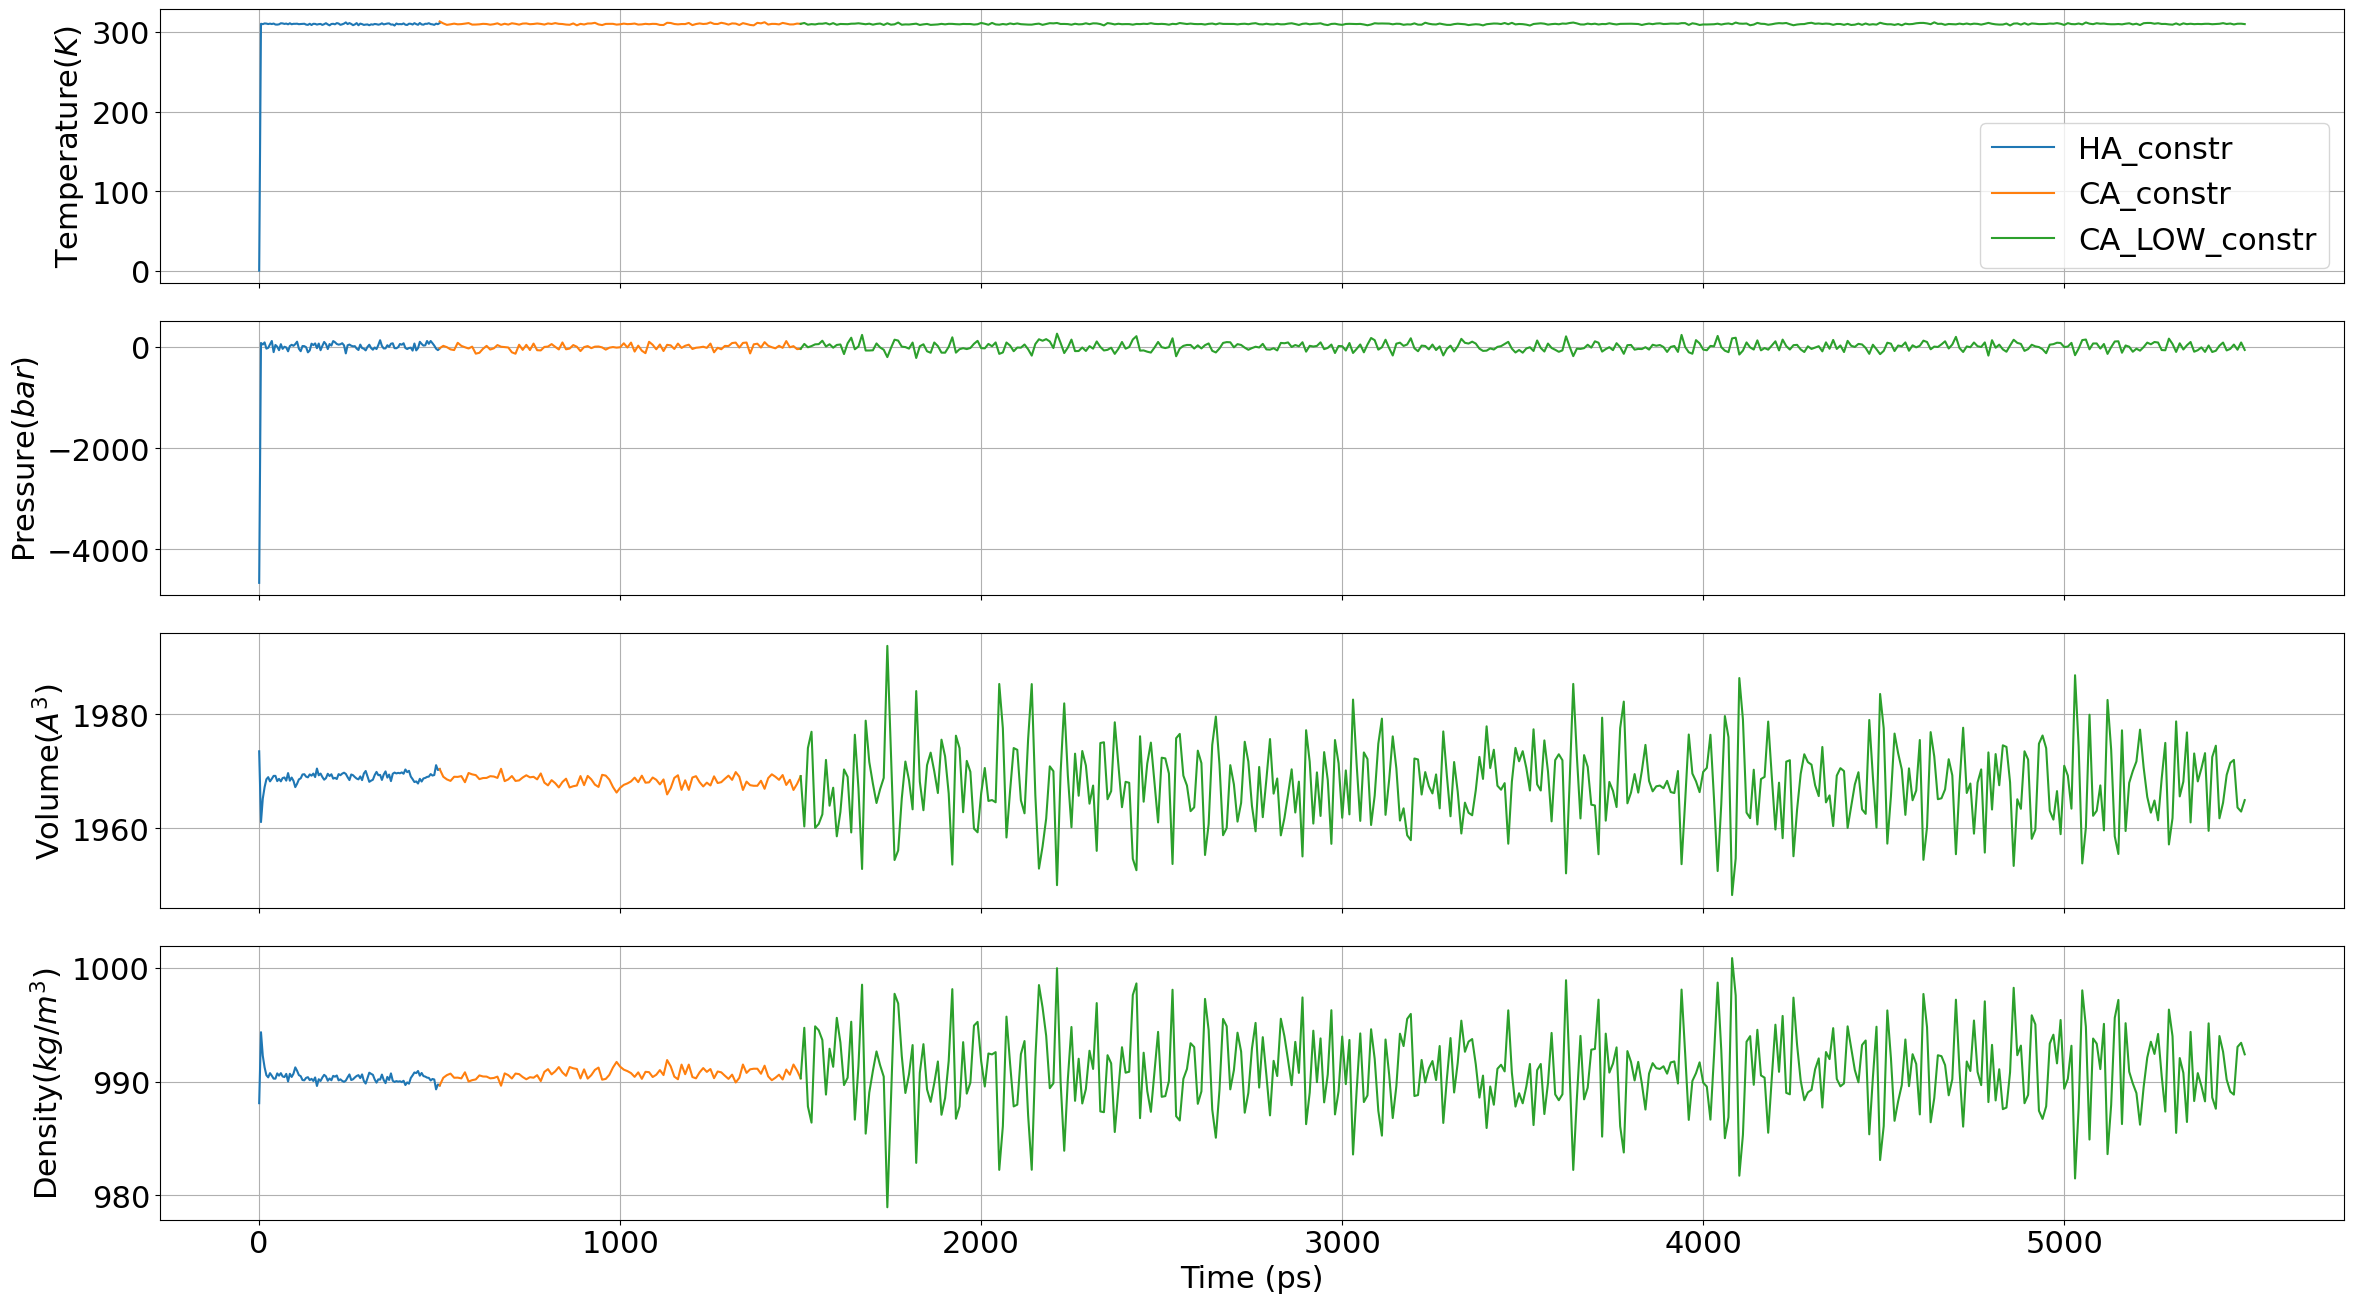

In [19]:
%%script true
plt.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(4, 1, figsize=(24,13.5), sharex=True, tight_layout=True)

for ax, quantity, unit in zip(axs, quantities, units):
    for df in (pd_1, pd_2, pd_3):
        ax.plot(df["Time (ps)"], df[quantity], label=str(df['label'][0]))
        ax.set_ylabel(quantity + "(" + unit + ")")
        ax.grid()

axs[0].legend()
axs[-1].set_xlabel("Time (ps)");

Looks okay to me. Fluctuations are high at the end because CA constraints are low, but there is a well-defined average.

### Plot RMSD

In [20]:
%%script true
# Define reference structure for RMSD calculation
ref_sys =  complex_sys.sys_history[1]
struct="Protein"

rmsd_pd_1 = complex_sys.sys_history[-2].get_rmsd([struct, struct], ref_sys=ref_sys)
rmsd_pd_2 = complex_sys.sys_history[-1].get_rmsd([struct, struct], ref_sys=ref_sys)
rmsd_pd_3 = complex_sys.get_rmsd([struct, struct], ref_sys=ref_sys)


rmsd_pd_1['label'] = 'HA_constr'
rmsd_pd_2['label'] = 'CA_constr'
rmsd_pd_2['time'] = rmsd_pd_2['time'] + rmsd_pd_1['time'].max()
rmsd_pd_3['label'] = 'CA_LOW_constr'
rmsd_pd_3['time'] = rmsd_pd_3['time'] + rmsd_pd_2['time'].max()

display(pd.concat([rmsd_pd_1, rmsd_pd_2, rmsd_pd_3]))


gmx rms -s molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/em/Init_em_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -f molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/00_equi_HA/equi_HA_dna_sequence_pseudomonas_negative_control_peptide_model_0.xtc -n molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no


gmx rms -s molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/em/Init_em_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -f molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/01_equi_CA/equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0.xtc -n molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no


gmx rms -s molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/em/Init_em_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -f molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_pseudomonas_negative_control_peptide_model_0.xtc -n molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.ndx -o tmp_rmsd.xvg -fit rot+trans -ng 1 -pbc no


,time,Protein,label
0,0.0,4.179875,HA_constr
1,5.0,4.167088,HA_constr
2,10.0,4.175864,HA_constr
3,15.0,4.179109,HA_constr
4,20.0,4.184353,HA_constr
...,...,...,...
396,5460.0,4.150241,CA_LOW_constr
397,5470.0,4.170699,CA_LOW_constr
398,5480.0,4.202528,CA_LOW_constr
399,5490.0,4.148477,CA_LOW_constr


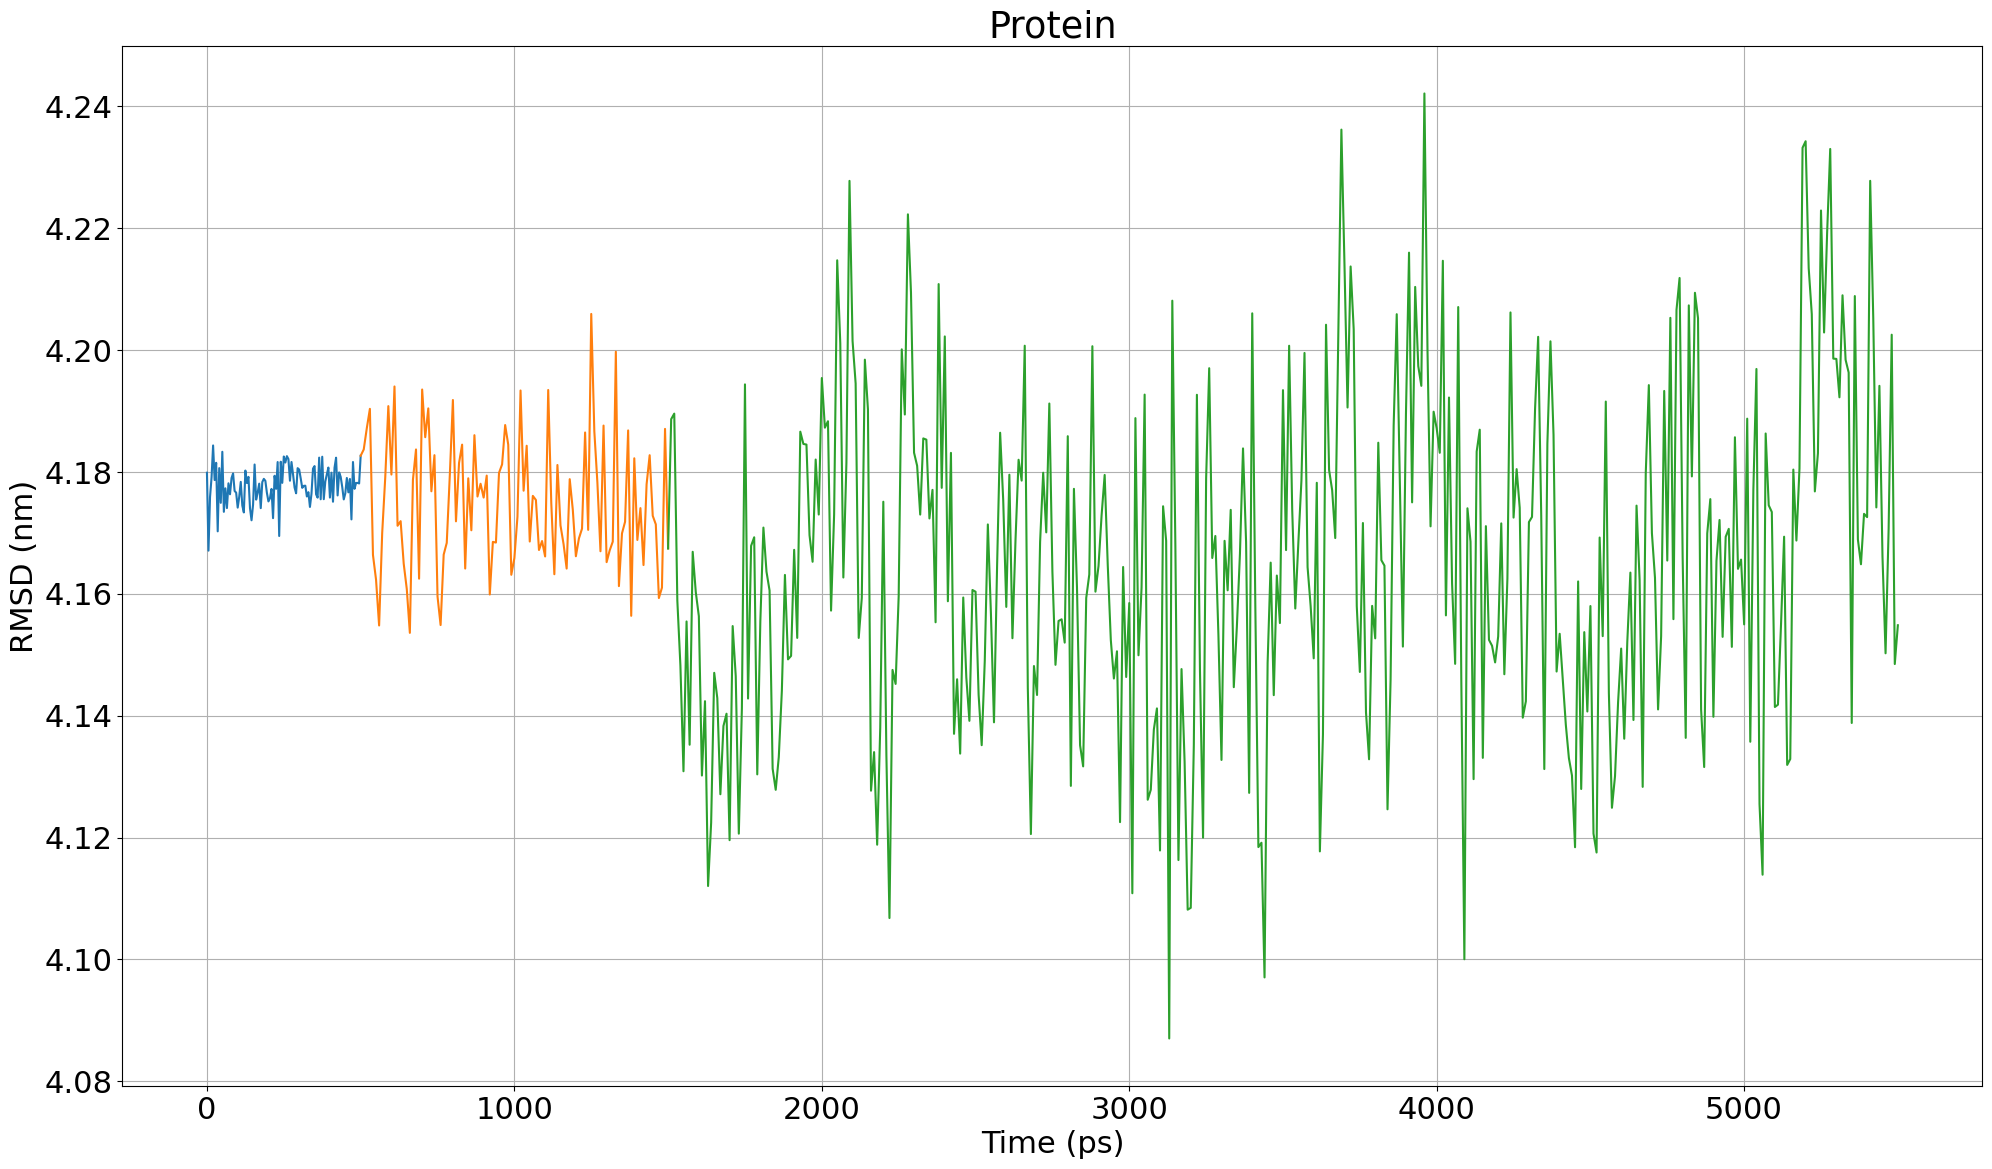

In [21]:
%%script true
fig, ax = plt.subplots(1, 1, figsize=(24,13.5))

for df in (rmsd_pd_1, rmsd_pd_2, rmsd_pd_3):
        ax.plot(df["time"], df["Protein"], label=str(df['label'][0]))
        
ax.set_title(struct)
ax.set_ylabel('RMSD (nm)')
ax.set_xlabel('Time (ps)')
plt.grid()

### Prepare Equilibration Trajectories for Viewing 

Do this by removing artefacts (centering) and smoothening rotational and translational degrees of freedom.

Solutions:

1. [https://gromacs.bioexcel.eu/t/issue-with-correcting-pbc-for-dna-separation-in-gromacs/11013]
2. [https://gromacs.bioexcel.eu/t/fix-two-separate-dna-strands-after-simulation-using-pbc-cluster/9704]
3. [https://mailman-1.sys.kth.se/pipermail/gromacs.org_gmx-users/2018-April/120016.html]


### Center trajectories as follows:

There is a common problem here in that the DNA strands aren't linked by covalent bonds, so PBC might pull them apart into adjacent boxes.

Solution is [here](https://gromacs.bioexcel.eu/t/issue-with-correcting-pbc-for-dna-separation-in-gromacs/11013). Implemented in workflow below.

Choose Protein_DNA for all selections
    
```bash

$ export fname=equi_HA_dna_sequence_101_peptide_model_0

$ gmx trjconv -pbc mol -f ${fname}.xtc -o ${fname}_mol.xtc -s ${fname}.tpr -n ../../dna_sequence_101_peptide_model_0_water_ion.ndx
$ gmx trjconv -center -ur compact -f ${fname}_mol.xtc -o ${fname}_mol_compact.xtc -s ${fname}.tpr -n ../../dna_sequence_101_peptide_model_0_water_ion.ndx
$ gmx trjconv -fit rot+trans -f ${fname}_mol_compact.xtc -o ${fname}_mol_compact_compact.xtc -s ${fname}.tpr -n ../../dna_sequence_101_peptide_model_0_water_ion.ndx
$ gmx trjconv -dump 0 -f ${fname}_mol_compact.xtc -o start.pdb-s ${fname}.tpr -n ../../dna_sequence_101_peptide_model_0_water_ion.ndx

```

Repeat for all other equilibrating trajectories as needed.

**Note:** Everything described above is implemented below in python now. Check out the next few cells:

### Prepare latest trajectories

In [22]:
%%script true
complex_sys.convert_trj(select='Protein_DNA\nProtein_DNA', pbc='mol')
complex_sys.convert_trj(select='Protein_DNA\nProtein_DNA', fit='rot+trans', pbc='none')

gmx trjconv -f molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_pseudomonas_negative_control_peptide_model_0.xtc -o molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_pseudomonas_negative_control_peptide_model_0_compact.xtc -s molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -ur compact -pbc mol -n molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.ndx


gmx trjconv -f molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_pseudomonas_negative_control_peptide_model_0_compact.xtc -o molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_pseudomonas_negative_control_peptide_model_0_compact_compact.xtc -s molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/02_equi_CA_LOW/equi_CA_LOW_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -ur compact -pbc none -fit rot+trans -n molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.ndx


### Prepare the last two sets of trajectories

In [23]:
%%script true
complex_sys.sys_history[-1].convert_trj(select='Protein_DNA\nProtein_DNA', pbc='mol')
complex_sys.sys_history[-1].convert_trj(select='Protein_DNA\nProtein_DNA', fit='rot+trans', pbc='none')

gmx trjconv -f molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/01_equi_CA/equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0.xtc -o molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/01_equi_CA/equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0_compact.xtc -s molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/01_equi_CA/equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -ur compact -pbc mol -n molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.ndx


gmx trjconv -f molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/01_equi_CA/equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0_compact.xtc -o molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/01_equi_CA/equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0_compact_compact.xtc -s molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/01_equi_CA/equi_CA_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -ur compact -pbc none -fit rot+trans -n molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.ndx


In [24]:
%%script true
complex_sys.sys_history[-2].convert_trj(select='Protein_DNA\nProtein_DNA', pbc='mol')
complex_sys.sys_history[-2].convert_trj(select='Protein_DNA\nProtein_DNA', fit='rot+trans', pbc='none')

gmx trjconv -f molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/00_equi_HA/equi_HA_dna_sequence_pseudomonas_negative_control_peptide_model_0.xtc -o molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/00_equi_HA/equi_HA_dna_sequence_pseudomonas_negative_control_peptide_model_0_compact.xtc -s molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/00_equi_HA/equi_HA_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -ur compact -pbc mol -n molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.ndx


gmx trjconv -f molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/00_equi_HA/equi_HA_dna_sequence_pseudomonas_negative_control_peptide_model_0_compact.xtc -o molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/00_equi_HA/equi_HA_dna_sequence_pseudomonas_negative_control_peptide_model_0_compact_compact.xtc -s molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/00_equi_HA/equi_HA_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -ur compact -pbc none -fit rot+trans -n molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.ndx


### Extract Initial Condition as PDB

In [25]:
%%script true
import os

file_dir = os.path.dirname(complex_sys.sys_history[-2].coor_file)
complex_sys.sys_history[-2].convert_trj(select='Protein_DNA\nProtein_DNA', specific_coor_out=file_dir+"/start.pdb", dump="0")

gmx trjconv -f molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/00_equi_HA/equi_HA_dna_sequence_pseudomonas_negative_control_peptide_model_0_compact_compact.xtc -o molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/00_equi_HA/start.pdb -s molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/sys_equi/00_equi_HA/equi_HA_dna_sequence_pseudomonas_negative_control_peptide_model_0.tpr -ur compact -pbc mol -dump 0 -n molecular_dynamics/dna_sequence_pseudomonas_negative_control_peptide_model_0/dna_sequence_pseudomonas_negative_control_peptide_model_0_water_ion.ndx


## Production MD 

tc-coupling groups are required here as well. See [gromacs-py manual](https://gromacs-py.readthedocs.io/en/latest/notebook/01_dna_ligand_ambertools.html#Production)

In [26]:
#%%script true
import pickle, datetime
chkpt_fname='checkpoint.equi_pseudomonas_20250323.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

In [27]:
#%%script true
#Parallelization
nthreads = int(os.environ.get('PBS_NCPUS', '12'))

#Set Parallelization
complex_sys.nt = nthreads
#complex_sys.ntmpi = 1
complex_sys.gpu_id = '0'

complex_sys.production(out_folder=prod_folder,
        nsteps=prod_step,
        tc_grps='Protein_DNA Water_and_ions',
        tau_t= '0.1 0.1',
        ref_t= '310 310',
        dt=dt, vsite='none', maxwarn=1, nstlist=200)

## Checkpointing for extending


In [28]:
#%%script true
import pickle, datetime
chkpt_fname='checkpoint.prod_pseudomonas_' + datetime.date.today().strftime("%Y%m%d") + '.pycpt'
with open(chkpt_fname, 'wb') as py_cpt:
    pickle.dump(complex_sys, py_cpt)

## Post-Production

In [29]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.prod_pseudomonas_20250323.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

### Prepare Production Trajectory for Viewing

## Final Steps
As in any simulation conducted with periodic boundary conditions, molecules may appear "broken" or may "jump" back and forth across the box. To recenter the protein and rewrap the molecules within the unit cell to recover the desired box shape, invoke trjconv. 

Choose "Protein_DNA" for centering and "Protein_DNA" (prot and ligand selection) for output.

**Note:** Try different commented options until one of them works.

In [30]:
#%%script true
complex_sys.center_mol_box(traj=True)
complex_sys.add_ndx("",ndx_name="dna_sequence_85_peptide_model_0_water_ion", folder_out=DATA_OUT)
#complex_sys.convert_trj(select='Protein_DNA\nProtein_DNA', pbc='whole')
#complex_sys.convert_trj(select='Protein_DNA\nProtein_DNA', pbc='mol')
complex_sys.convert_trj(select='Protein_DNA\nProtein_DNA', pbc='cluster')
complex_sys.convert_trj(select='Protein_DNA\nProtein_DNA', fit='rot+trans', pbc='none')

#### Extract production initial condition
Optionally, extract the first frame of the final prod traj (latest from history, as the running one got updated) into a `pdb` for loading into post processing.

In [31]:
#%%script true
import os
file_dir = os.path.dirname(complex_sys.coor_file)
complex_sys.convert_trj(select='Protein_DNA\nProtein_DNA', specific_coor_out=file_dir+"/prod_start.pdb", dump="0")